# 自己回帰移動平均 （Autoregressive Moving Average, ARMA)

## 理論

- $(p,q)$次ARMAモデル: $y_t=c+\phi_1y_{t-1}+\cdots+\phi_py_{t-p}+\varepsilon_t+\theta_1\varepsilon_{t-1}+\cdots+\theta_q\varepsilon_{t-q}$<br>
- 確率的な変動成分を回帰させるMAモデルとモデル自身の出力を回帰させるARモデルの組み合わせ．
    - $q$次のMAモデル: $y_t=c+\varepsilon_t+\theta_1\varepsilon_{t-1}+\cdots+\theta_q\varepsilon_{t-q}$
        - 移動平均らしさはあまり感じられないが、**重み付き平均**と考えればまあ納得
        - 分析者の知らない要因で生じる自己相関を表現可能である
        - 例えば商品の売り上げを分析する際に、分析者の知らないクーポンが発行されていたりするケースで使える
    - $p$次のARモデル: $y_t=c+\phi_1y_{t-1}+\cdots+\phi_py_{t-p}$
        - 非定常な時系列にも使える（パラメータによって定常だったり非定常だったりするため）
- モデルの安定性はARモデルパラメータに依存（特性方程式の全ての解の絶対値が1より大きいのであれば定常）
    - MA過程は常に定常なのでARMAモデルの定常性には影響なし
- 自己相関をもつ時系列であることを想定するため、実務では自己相関の検定をまず行う？
    - かばん検定(portmanteau test)：$1\sim m$次のいずれかに自己相関があるかどうか検定
        - 帰無仮説 $H_0$: $1\sim m$次の全ての自己相関がない
        - $m$が小さすぎると高次の自己相関を見落とす
        - $m$が大きすぎると検定の検出力 (power, 正しく帰無仮説を棄却できる確率) が小さくなる可能性


## 参考URL

https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/tsa_arma_0.ipynb

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
# グラフを横長にする
rcParams['figure.figsize'] = 15, 6
# 文字サイズの指定
rcParams["font.size"] = 18


import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [3]:
from statsmodels.graphics.api import qqplot

# Sunspots Data の概要

In [4]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [5]:
dta = sm.datasets.sunspots.load_pandas().data
dta.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


In [6]:
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del dta["YEAR"]
dta.head()

,SUNACTIVITY
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0


Text(0, 0.5, 'Sunactivity')

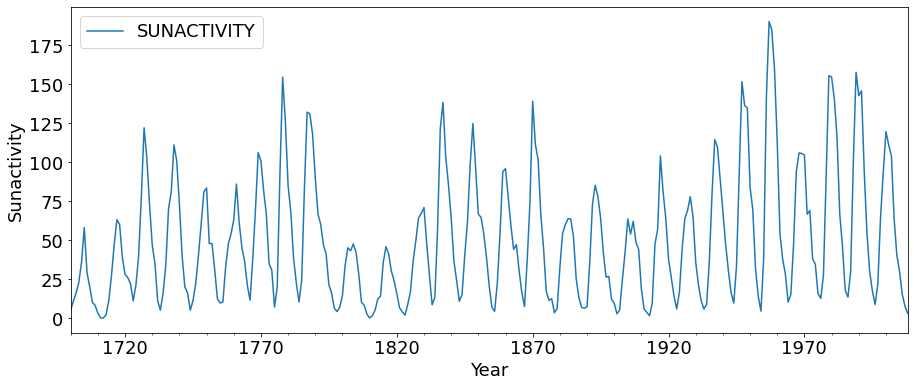

In [7]:
dta.plot(figsize=(15,6));
plt.xlabel('Year')
plt.ylabel('Sunactivity')

# 自己相関・偏自己相関のプロット
- 自己相関のグラフから読み取れること
    - 元の時系列データにはおよそ10〜11の周期を持っている
- 偏自己相関のグラフから読み取れること
    - ラグ 1, 2 間で真に強い相関がある / ラグ 6, 7, 8, 9 間には若干の相関

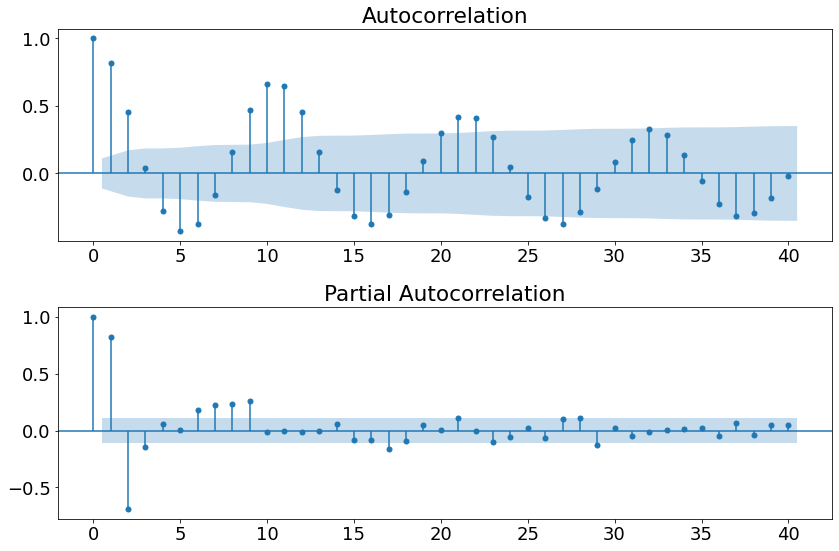

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)
plt.tight_layout()

# ARMA モデルへのフィッテング
**引数**
order：the number of  (AR parameters, difference, MA parameters)
freq: ???

以下は (2,2) 次のARMAモデルを採用．

In [9]:
arma_mod22 = ARIMA(dta, order=(2, 0, 2)).fit()

/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'
/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


## 結果の表示

### 上段にある指標の説明
- Log Likelihood: -1304.436
    - 対数尤度のことで、大きいほど実データの分布を再現できているといえる
    - あまり良い精度ではなさそう
    - どの程度が良いかは絶対的な値は存在する？
    
- 情報量規準 (information criterion): <font color="red">最尤法の推定結果に基づいて最適なモデルを選択する</font>客観評価指標
    - **情報量規準の小さい（精度もよく軽量である）モデル**を選択するための指標
    - 一般的なIC
        - $IC=-2\mathcal{L}(\hat{\theta})+p(T)k$
            - $\hat{\theta}$: パラメータの最尤推定値
            - $\mathcal{L}(\hat{\theta})$: 対数尤度の最大値（最尤法の結果）
            - $T$: モデルの推定に用いたサンプル数
            - $p$: 何らかの関数
            - $k$: パラメータ数
        - 第1項：モデルの表現能力
        - 第2項：モデルの複雑さに対するペナルティ→過学習の抑制に繋がる
        - パラメータを増やすペナルティ以上の改善が見られるかどうかを確認できる
        
    - 赤池情報量基準 (Akaike’s Information Criterion, AIC)
        - $AIC = -2\mathcal{L}(\hat{\theta})+2k$
        
    - Schwarz 情報量規準　(SIC) / ベイズ情報量規準 (Bayesian Information Criterion, BIC)
        - $SIC\ (BIC) = -2\mathcal{L}(\hat{\theta})+\log(T)k$
    
    - AIC vs SCI
        - 十分なサンプル数が与えられる ($T=\infty$) 時、**AR過程**に関して以下のことが知られている
            - AIC: 真の次数(パラメータ数)より少ない次数が選択されることはないが、<font color="blue">大きい次数が選択される可能性がある</font>
            - SIC: <font color="red">必ず真の次数（パラメータ数）と同じ次数をもつモデルが選択できる</font>
        - とはいえ、AICの方が劣っているというわけではない
            - 真の過程における次数がめちゃめちゃ大きい場合: AR$(\infty)$
                - AICはある種の漸近最適性を有する
            - AICによって過大なモデルが選択された場合:
                - サンプル数が大きくなるにつれて、過大な部分のパラメータの最尤推定量が０に収束する<br>
                  → 過大なモデルの選択はそれほど問題にならない
        - 結局のところ、AICとSICが異なるモデルを選択した場合、**どちらを採用するかは一概には言えず、分析者に委ねられてしまうらしい**
        
    - HQIC (Hannan-Quinn information criterion)
        - $HQIC = -2\mathcal{L}(\hat{\theta})+2\log(\log(T))k$
        - `Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach ` 曰く、実用上はあまり使われないとのこと
            
        
- Covariance Type: パラメータ推定に使用する共分散行列の推定法
    - fit メソッドを参照
    
   
### 中段にある指標の説明

**パラメータの推定結果**
- $y_t=49.7502+1.4460y_{t-1}-0.7458y_{t-2}+\varepsilon_t-0.1405\varepsilon_{t-1}+0.0691\varepsilon_{t-2}$
- $\varepsilon_t \sim {\rm W.N.}(269.5971)$

    
**各説明**
- 回帰係数 (coefficient, coef)
    - フィッティングの結果、得られたパラメータの数値
- 標準誤差：(standard error, std err)
    - 推定量の標準偏差を表す（つまりは推定値がどれほどばらついていて不安定かがわかる）
    - 一般に標本平均の標準偏差を意味する
    - 中心極限定理 (サンプル数 $n$ が大きくなるにつれてサンプルの平均値の分布が正規分布 $N(\mu, \sigma^2/n)$ に従う)　に基づいて算出
        - 標本平均の標準偏差: $\sqrt{\sigma^2/n}$
        - 実際は不偏分散を用いるので→$\sqrt{s^2/n}$
    - 下記結果を見ると、（当然のような気がするが）数値が大きい係数ほどばらついている様子
- z: 係数とその標準誤差の間の比率を表す統計量
    - z = coef / std_err
    - z=$\pm$2 が信頼区間（両側） 5% の両端
- P>|z|: P値
    - 有意水準 (5%) を下回っているかどうか確認せよ
    - 下の例だと、MAパラメータが信頼できない係数だと思われる
- [0.025 0.975]: 信頼区間
    - この値の範囲内が95%の許容範囲に相当
    
    
    
### 下段にある指標の説明
- 各種検定のようだが、<font color="blue">よくわからない</font>

In [10]:
print(arma_mod22.summary())

                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  309
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1304.436
Date:                Mon, 08 Mar 2021   AIC                           2620.873
Time:                        16:33:14   BIC                           2643.273
Sample:                    12-31-1700   HQIC                          2629.828
                         - 12-31-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7502      3.667     13.567      0.000      42.563      56.938
ar.L1          1.4460      0.077     18.755      0.000       1.295       1.597
ar.L2         -0.7458      0.064    -11.681      0.0

## ダービン・ワトソン統計量
- 2に近いほど自己相関がないと判断できる統計量
- 下記結果より残差に自己相関がないことがわかる→ARMAモデルの残差はホワイトノイズなので期待した通りの結果

In [11]:
sm.stats.durbin_watson(arma_mod22.resid.values)

1.9698239538456137

plotしてみても相関なさそうでいい感じ

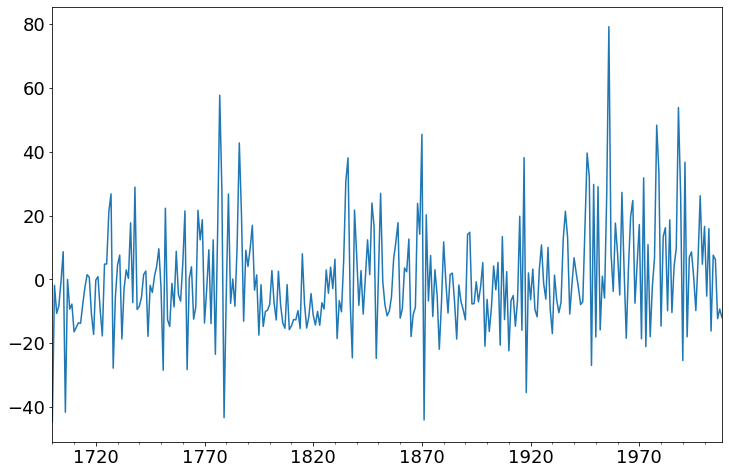

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_mod22.resid.plot(ax=ax);

## 残差の正規性の検定

- statistic: $({\rm z\text{-}score\ by\ skewtest})^2+({\rm z\text{-}score\ by\ kurtosistest})^2$
    - skewtest: 正規分布に対する歪度（左右対称性の崩れ）を検定
    - kurtosistest: 正規分布に対する尖度（どれだけ尖っているか）を検定
- ここでの帰無仮説は**データに正規性がある**ということ
    - p値が有意水準 (5%) を下回ってるので、<font color="red">残差に正規性はない</font>
    - ARMAモデルは正規性のある残差を想定するため、構築したモデルは<font color="blue">ふさわしくない</font>

In [13]:
resid = arma_mod22.resid
stats.normaltest(resid)

NormaltestResult(statistic=48.64005630447345, pvalue=2.7412331412212944e-11)

## Q-Q プロット
データが理論的な確率分布に従っているか確認できる
対角線に乗っかるほど理論通りの結果といえる

- Q: 分位数 (Quantile)
- 観測データの分位数$q_0$と仮定する確率分布の分位数$q_p$を$(q_p,q_0)$としてプロット (縦軸・横軸は逆もあり得る)
    - 観測データの各分位数はソート順に定まる
    - 仮定する確率分布モデルの分位数は分位関数 (Quantile Function, QF) により算出
        - 分位関数は累積分布関数 (Cumulative Distribution Function, CDF) の逆関数
        - $CDF^{-1}(p)=QF(p)$: $p$は各分位数における累積確率
        - 累積確率に対応する理論上の分位数が取得可能
  
  
- 結果より対角線(赤)におおよそ乗っかっているようにも思えるが、値が大きいサンプルが正規分布から外れているずれていることがわかる
    - 先の正規性の検定で帰無仮説が棄却されたことと矛盾ない
    - Q-Qプロットを見て、これがどの程度同一の分布かは経験の中でわかっていくはず

1700-12-31   -44.750159
1701-12-31    -1.899717
1702-12-31   -10.684842
1703-12-31    -8.317596
1704-12-31    -0.681090
                ...    
2004-12-31     7.563063
2005-12-31     6.157800
2006-12-31   -12.334231
2007-12-31    -9.328951
2008-12-31   -11.983204
Length: 309, dtype: float64


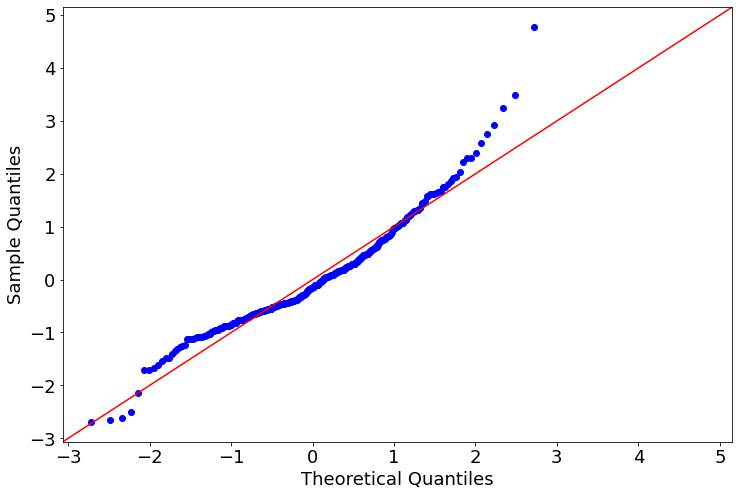

In [14]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
print(resid)
fig = qqplot(resid, line='45', ax=ax, fit=True)

## 残差の自己相関・偏自己相関

- 自己相関・偏自己相関共に高次の相関がほぼない
- ただ10次付近などで自己相関・偏自己相関が若干あるようなので、<br>
  その相関をモデルに含めるような改善を目指す？（実務上の試行錯誤の話？）

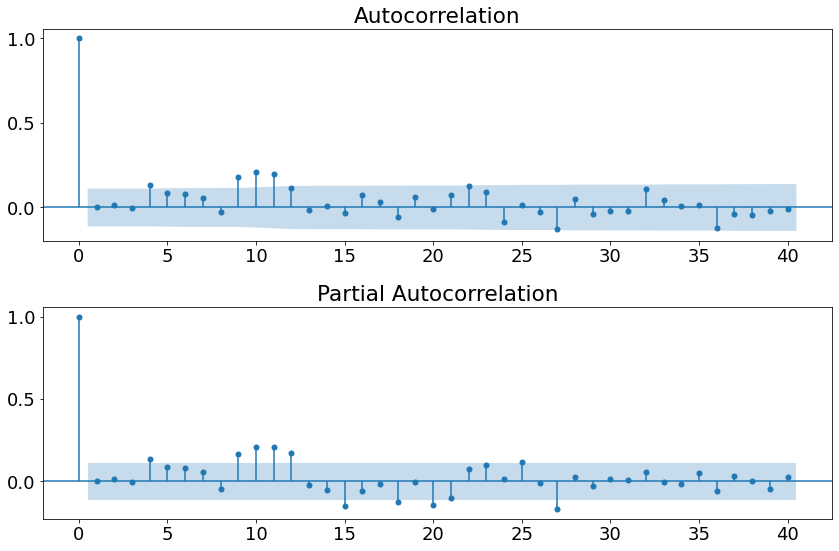

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.tight_layout()

### 自己相関関数の算出
- sm.tsa.acf の出力
    - r: 自己相関関数
    - q: Ljung-Box (リュング・ボックス) 検定における統計検定量（Q値）
        - 帰無仮説：あるラグにおいてどの時刻にも自己相関が存在しない
        - 棄却された場合、いずれかの時刻において自己相関が存在する
    - p: p値（有意水準と比較せよ）

- 結果の分析
    - ラグが9~で有意水準 (5%) を上回っている→自己相関がどこかに存在
    - やはりモデルがふさわしくない

In [16]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), fft=True, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.002493   0.001939  9.648808e-01
2.0   0.014239   0.065406  9.678259e-01
3.0  -0.005351   0.074397  9.947218e-01
4.0   0.133296   5.672698  2.249611e-01
5.0   0.082692   7.834301  1.656072e-01
6.0   0.079109   9.819141  1.324779e-01
7.0   0.054149  10.752162  1.498009e-01
8.0  -0.027929  11.001196  2.016314e-01
9.0   0.178672  21.227301  1.167852e-02
10.0  0.210210  35.429462  1.054489e-04
11.0  0.197664  48.029094  1.410720e-06
12.0  0.114037  52.236884  5.628327e-07
13.0 -0.016061  52.320636  1.185899e-06
14.0  0.010618  52.357364  2.446085e-06
15.0 -0.030169  52.654875  4.400078e-06
16.0  0.074655  54.482848  4.323221e-06
17.0  0.032947  54.840087  7.269391e-06
18.0 -0.058684  55.977356  8.986078e-06
19.0  0.059406  57.146802  1.084176e-05
20.0 -0.010737  57.185134  1.924011e-05
21.0  0.073772  59.001129  1.806790e-05
22.0  0.129146  64.585828  4.569606e-06
23.0  0.092483  67.459760  2.981154e-06


/Users/t-hayasaka/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:652: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


## 構築したモデルによる推論

In [22]:
predict_sunspots = arma_mod22.predict('1990', '2012', dynamic=True)
print(predict_sunspots)

1990-12-31    168.057758
1991-12-31    142.223420
1992-12-31     95.227564
1993-12-31     46.540406
1994-12-31     11.190537
1995-12-31     -3.612433
1996-12-31      1.347705
1997-12-31     19.560463
1998-12-31     42.196368
1999-12-31     61.343870
2000-12-31     72.148295
2001-12-31     73.490531
2002-12-31     67.373125
2003-12-31     57.526387
2004-12-31     47.850722
2005-12-31     41.203868
2006-12-31     38.809032
2007-12-31     40.303560
2008-12-31     44.250759
2009-12-31     48.843676
2010-12-31     52.541013
2011-12-31     54.461766
2012-12-31     54.481557
Freq: A-DEC, Name: predicted_mean, dtype: float64


## 推論誤差の算出

In [23]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [24]:
mean_forecast_err(dta.SUNACTIVITY, predict_sunspots)

5.229898002500649